

<h1 style="text-align: center;"><b>Линейная регрессия и их оптимизация.</b></h1>

![Линейная регрессия](https://bigdataschool.ru/wp-content/uploads/2020/10/1.jpg)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ - целевая переменная (что мы хотим предсказать), $x_i$ - признак объекта $х$, $w_i$ - вес $i$-го признака, $b$ - bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ - скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ - столбец размера $n$, $X$ - матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ - вектор весов размера $k$.

**Лосс:**
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 = \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

### 1.1 Линейная регрессия из sklearn

In [62]:
from sklearn.linear_model import LinearRegression

`LinearRegression` из библиотеки `scikit-learn` - это один из наиболее распространенных (готовых) алгоритмов для решения задач линейной регрессии.

### Основные параметры

1. **fit_intercept** (по умолчанию True):
   - Этот параметр определяет, следует ли вычислять смещение (пересечение) при обучении модели. Если `True`, то модель будет учитывать это значение; если `False`, то она будет проходить через начало координат (0,0).

2. **normalize** (по умолчанию False):
   - Если `True`, то данные будут нормализованы перед применением линейной регрессии, что может быть полезно в некоторых случаях. Однако, начиная с версии 0.24, этот параметр устарел, и рекомендуется предварительно нормализовать данные с использованием `StandardScaler` или другого метода.

3. **copy_X** (по умолчанию True):
   - Если `True`, данные входного массива X будут скопированы перед обучением модели. Если `False`, то изменения могут быть внесены непосредственно в X.

4. **n_jobs** (по умолчанию None):
   - Параметр, который позволяет задать количество потоков для выполнения вычислений. Если `-1`, используется все доступные ядра процессора.

### Как хранятся веса модели

После обучения модели `LinearRegression` веса модели хранятся в атрибуте `coef_`, а свободный член (смещение) — в атрибуте `intercept_`.

- **coef_**:
  - Это массив, который содержит коэффициенты (веса) для каждой из входных переменных. Для решения задачи с k признаками размерность этого массива будет (k,).

- **intercept_**:
  - Это скалярное значение, представляющее собой смещение модели; он добавляется к линейной комбинации входных признаков.

Полный набор атрибутов модели можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [63]:
sk_reg = LinearRegression()

Попробуем обучить модель на нанглядных данных. Для начала сгенерируем их искусственно для теста моделей.

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
def linear_expression(x):
    return 3 * x + 6

In [66]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

Нанесем точки выборки и зависимость на график для наглядности

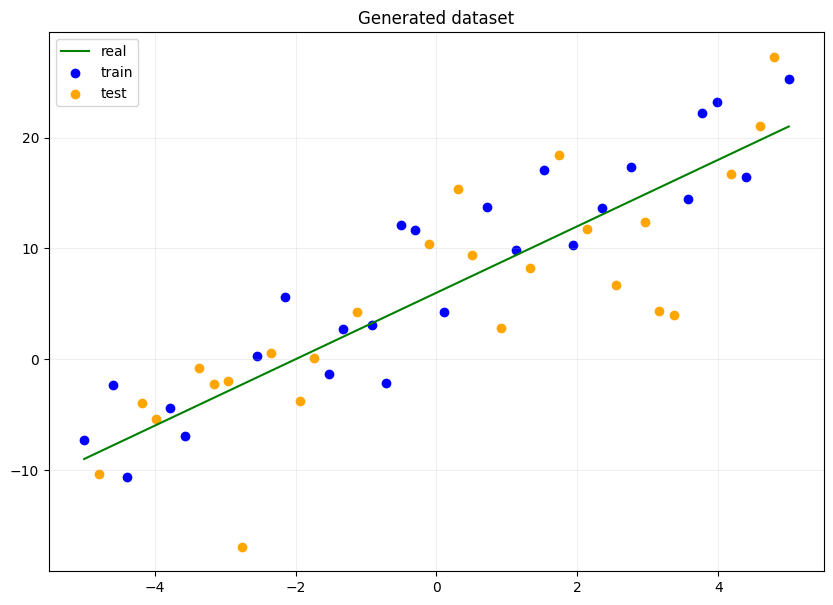

In [67]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [68]:
sk_reg.fit(X_train[:, np.newaxis], y_train)

LinearRegression()

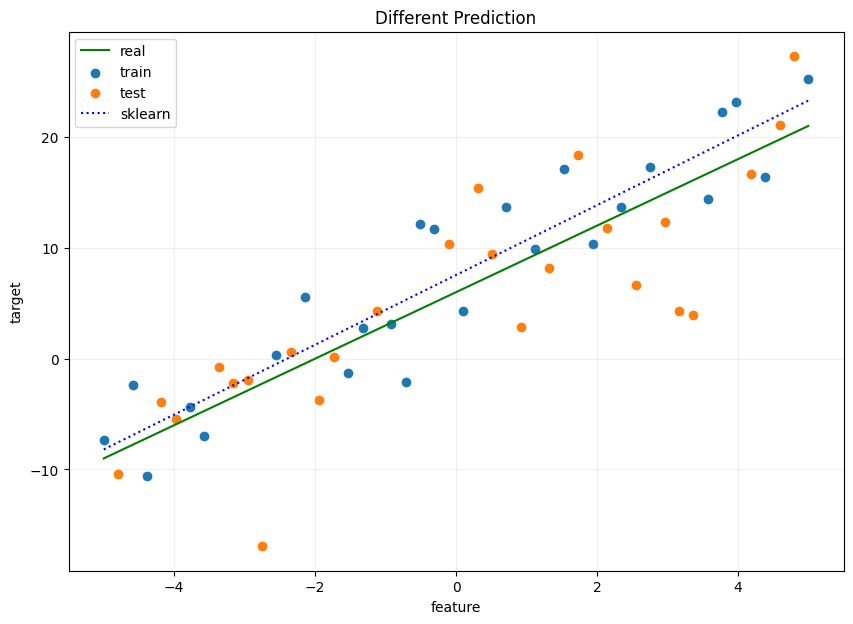

In [69]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='b', linestyle=':')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### 1.2 Аналитическое решение



Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

Реализуем класс линейной регрессии с помощью этой формулы.

### Обязательно сделайте свою копию ноутбука (Файл -> Создать копию на диске)

In [70]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1

        n, k = X.shape

        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        X_train_transpose = np.transpose(X_train)

        #self.w = np.dot(np.dot(np.linalg.inv(np.dot(X_train_transpose, X_train)), X_train_transpose), y)
        self.w = (np.linalg.inv(X_train_transpose @ X_train) @ X_train_transpose) @ y

        return self

    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def get_weights(self):
        return self.w

Обучим модель на трейне и предскажем результаты на тесте

array([3.14783575, 7.54907405])

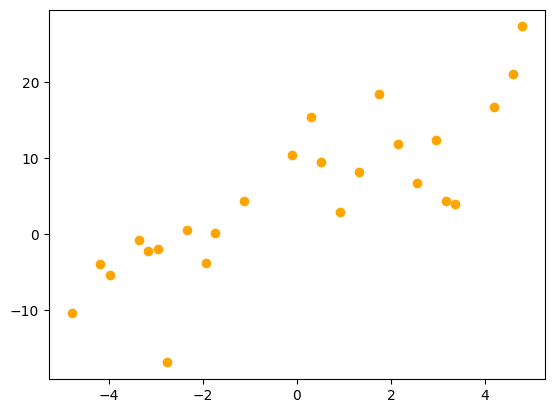

In [71]:
regressor = MyLinearRegression()
plt.scatter(X_test, y_test, label='test', c='orange')


regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

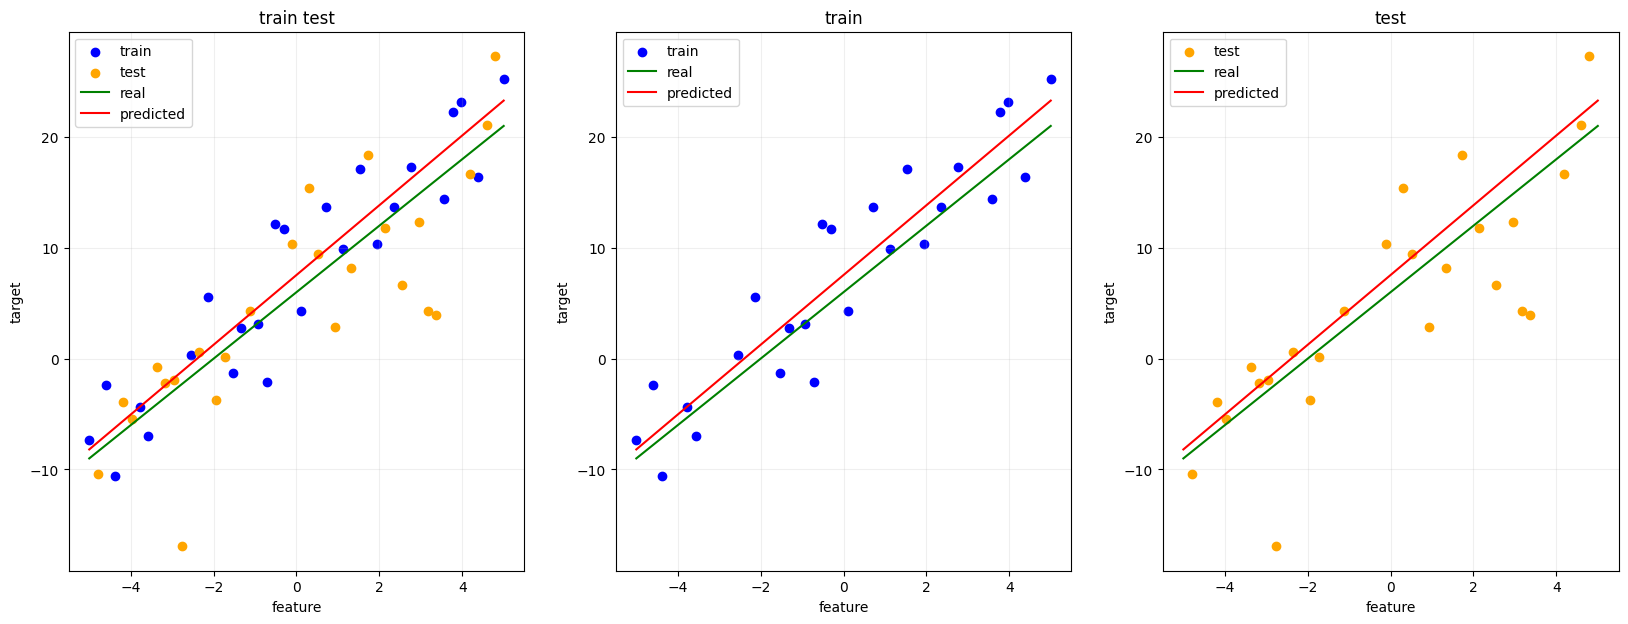

In [72]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

Сравним с реализацией из sklearn

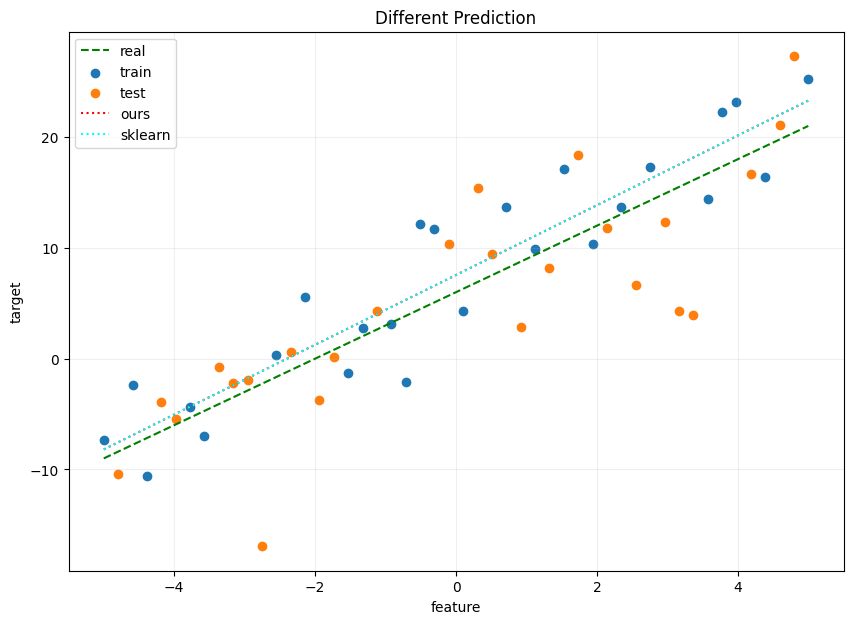

In [73]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g', linestyle='--')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='ours', c='r', linestyle='dotted')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='cyan', linestyle='dotted')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

#### Результаты

Train MSE:  13.762386047446546
Test MSE:  38.90549572285435


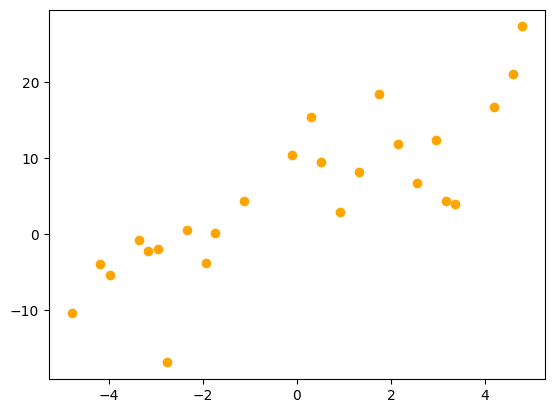

In [74]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])
plt.scatter(X_test, y_test, label='test', c='orange')


print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Попробуйте вычислить ΜΑΕ (mean absolute error)

In [75]:
# ваш код

### 1.2. Градиентная оптимизация

### Актуально для тех, кто не ходил на лекции Светланы Юрьевны... (или забыл всё за лето)

![Да кто этот ваш градиентный спуск...](https://habrastorage.org/r/w780q1/getpro/habr/upload_files/f4c/dce/668/f4cdce668582ea6fdc67223e40f18b93.jpg)


Обращение матрицы - очень долгая и дорогая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

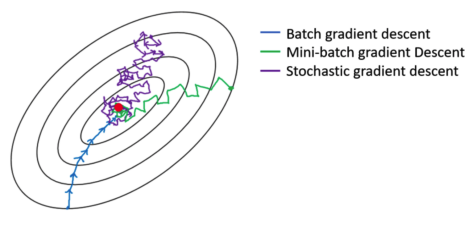

**Цель:** Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

**Предполагаемая зависимость:** $Y = Xw$, где $Y \in \mathbb{R}^{n\times 1}, X \in \mathbb{R}^{n\times m}, w \in \mathbb{R}^{m\times 1}$


**Минимизируемая функция:**
$$
L(y_{pred}, Y) = \frac{1}{n} ||y_{pred} - Y||^2 = \frac{1}{n}||Xw - Y||^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

**Градиент относительно $w$:**
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

### Вычисление лосса и градиента, наверное, выглядит для нас примерно так...

![Очевидно...](https://cs12.pikabu.ru/images/big_size_comm/2019-07_2/1562759902131988147.jpg)

In [76]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!

        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []

        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w = self.w - lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):

        grad = ((2 / X.shape[0]) * np.transpose(X)) @ (y_pred - y)

        return grad

    def get_losses(self):
        return self.losses

#### Тестирование

Посчитаем предсказания на сгенерированном датасете

In [77]:
regressor = MyGradientLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

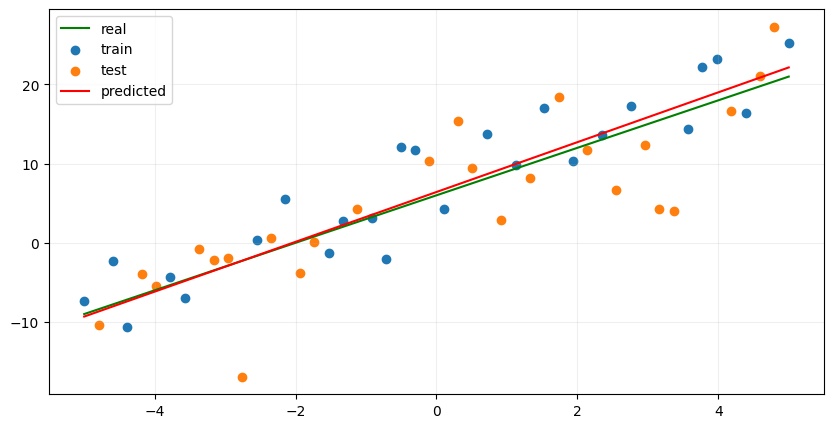

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

Построим таккже график лосса во время обучения

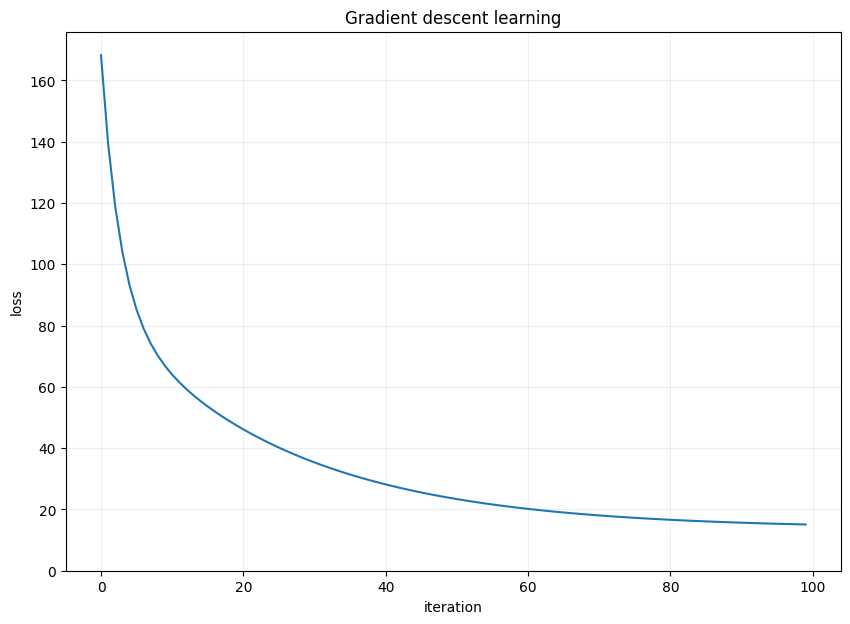

In [79]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

### 1.3 SGD

Добавим к нашему градиентному спуску сэмплирование мини-батча, по которому будем считать градиент


In [80]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD -- это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        # Обратите внимание, что должна выбираться подвыборка,
        # можно вызывать с помощью индекса [inds]

        X_subset = X[inds]
        y_subset = y[inds]
        y_pred_subset = y_pred[inds]

        grad = ((2 / X_subset.shape[0]) * np.transpose(X_subset)) @ (y_pred_subset - y_subset)

        return grad

#### Тестирование

Проведем аналогичный расчет на сгенерированном датасете

In [81]:
regressor = MySGDLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

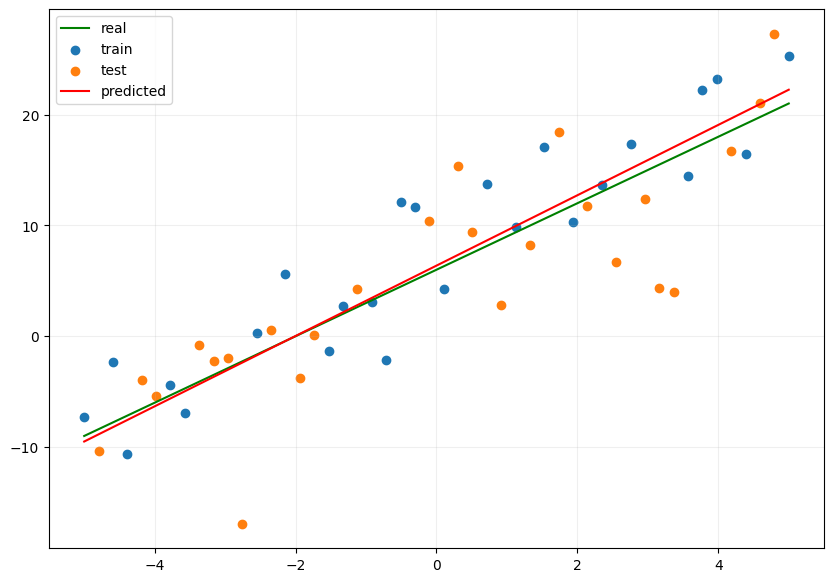

In [82]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

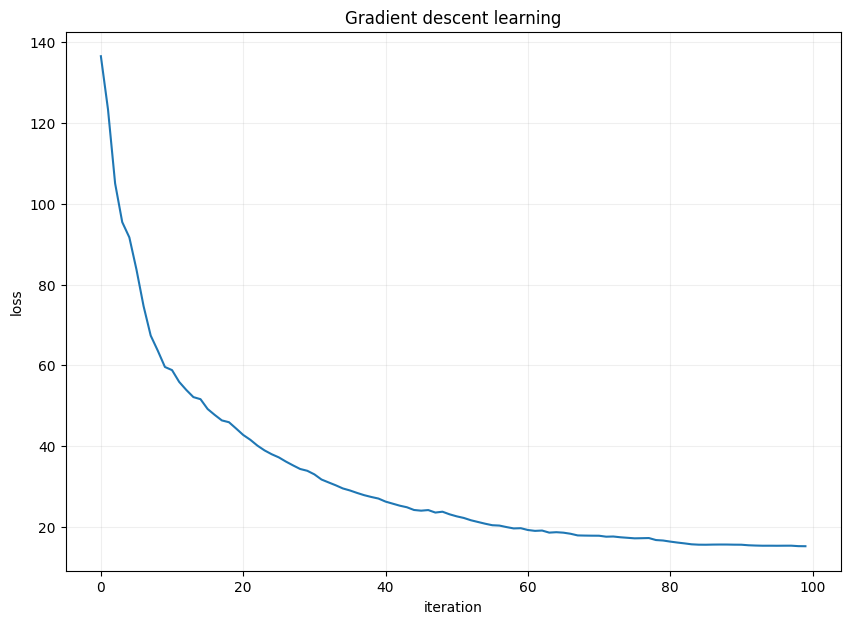

In [83]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

Протестируем меняя количество элементов для расчета градиента

In [84]:
n_samples = [1, 2, 4]

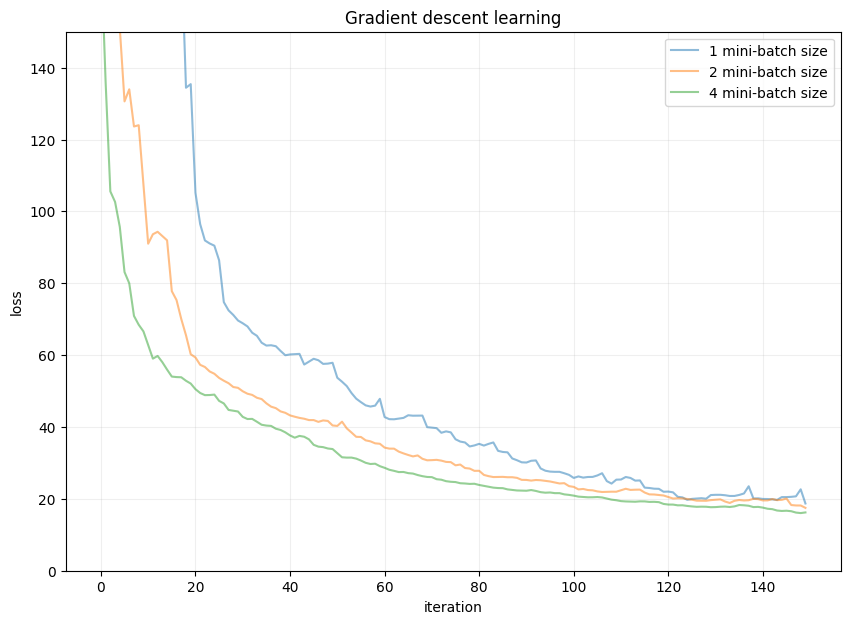

In [85]:
plt.figure(figsize=(10, 7))

for ns in n_samples:
    l = MySGDLinearRegression(fit_intercept=True, n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

Как видно по графикам размер подвыборки влияет на стабильность сходимости (чем меньше, тем больше и резче изменения весов).
При этом количество итераций для минимизации примерно одинаково.